# MA 541 - Final Project


In [ ]:
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 3.4 MB/s eta 0:00:00


In [ ]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, gamma, uniform, lognorm, ttest_ind, levene, f_oneway, probplot
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import pingouin as pg
from sklearn.preprocessing import OneHotEncoder
import itertools
from sklearn.linear_model import LassoCV
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, RocCurveDisplay

# Data Preprocessing

In [ ]:
# Download latest version
path = kagglehub.dataset_download("saurabhbadole/bank-customer-churn-prediction-dataset")
print("Path to dataset files:", path)

# List all files in the dataset directory
files = os.listdir(path)
print("Files in dataset:", files)

# Load dataset into a DataFrame
df = pd.read_csv(os.path.join(path, "Churn_Modelling.csv"))

df.head()

Path to dataset files: /kaggle/input/bank-customer-churn-prediction-dataset
Files in dataset: ['Churn_Modelling.csv']


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
# Exploratory Data Analysis (EDA)
print(df.info())
print(f'Count of duplicated rows: {df.duplicated().sum()}')
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None
Count of duplicated rows: 0


There are 14 variables from the initial data. There are no missing values or duplicate rows present, so data cleaning is not necessary.

Variable Breakdown:
*   Quantatative Variables: CreditScore, Tenure, Age, Balance, NumOfProducts, EstimatedSalary
*   Categorical Variables: Geography, Gender, HasCrCard, IsActiveMember, Exited

RowNumber, CustomerId, and Surname are not features of consideration for statistical analysis, since they are just identifiers for each observation.

## Summary Statistics and Data Visualization

In [ ]:
# Descriptive Stats
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [ ]:
# Additional Stats: Range, Mode
quantitative_vars = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
qualitative_vars = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited']

# Range - quantitative variables
ranges = {col: df[col].max() - df[col].min() for col in quantitative_vars}

# Mode - quantitative and qualitative
modes_old = {col: df[col].mode()[0] for col in quantitative_vars + qualitative_vars}
modes = {k: v.item() if isinstance(v, (np.int64, np.float64)) else v for k, v in modes_old.items()}
print(ranges)
print(modes)

{'CreditScore': 500, 'Age': 74, 'Tenure': 10, 'Balance': 250898.09, 'NumOfProducts': 3, 'EstimatedSalary': 199980.90000000002}
{'CreditScore': 850, 'Age': 37, 'Tenure': 2, 'Balance': 0.0, 'NumOfProducts': 1, 'EstimatedSalary': 24924.92, 'Geography': 'France', 'Gender': 'Male', 'HasCrCard': 1, 'IsActiveMember': 1, 'Exited': 0}


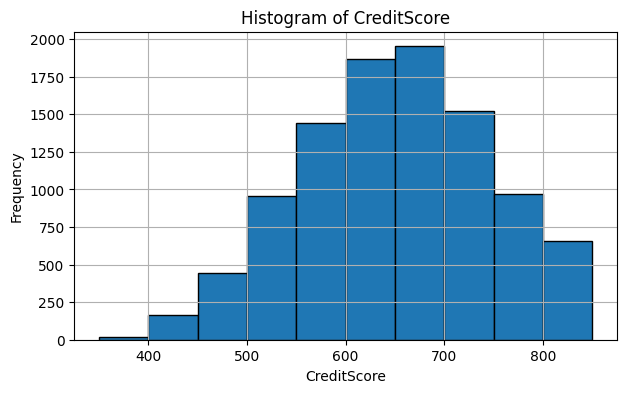

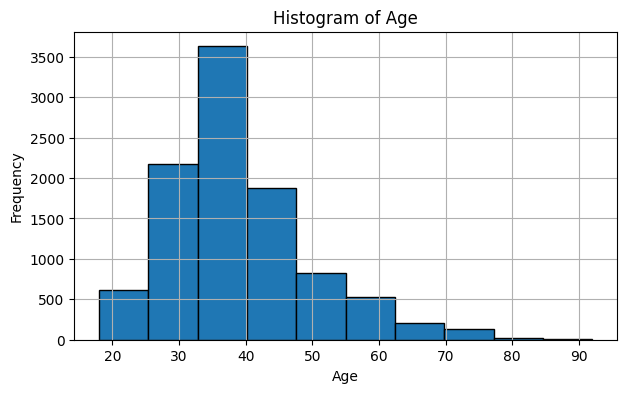

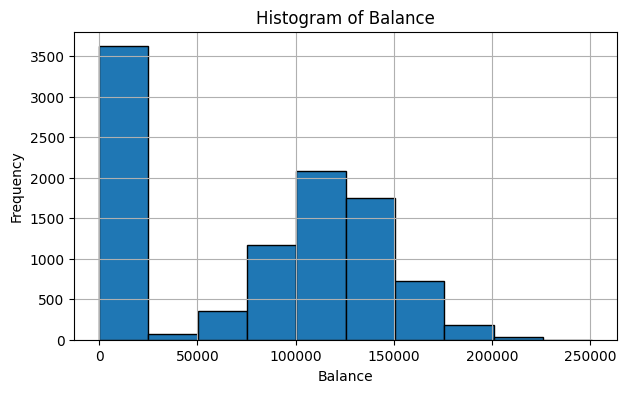

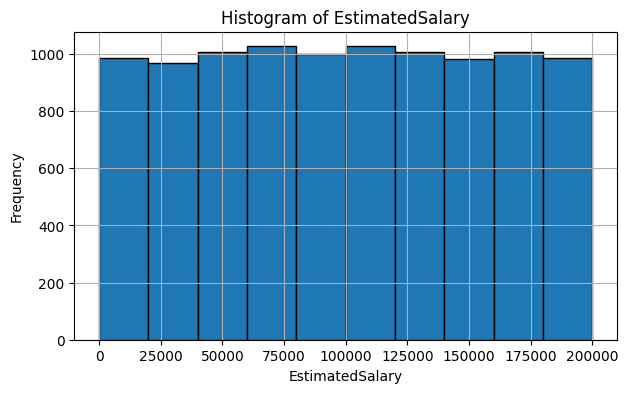

In [ ]:
# Histograms for continuous variables
continuous_vars = ['CreditScore', 'Age', 'Balance','EstimatedSalary']

for var in continuous_vars:
    plt.figure(figsize=(7, 4))
    plt.hist(df[var], edgecolor='black')
    plt.title(f'Histogram of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

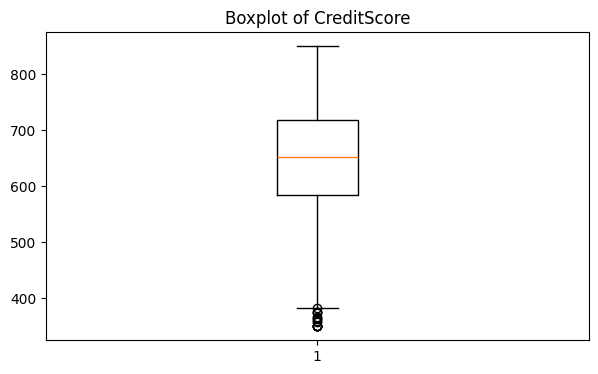

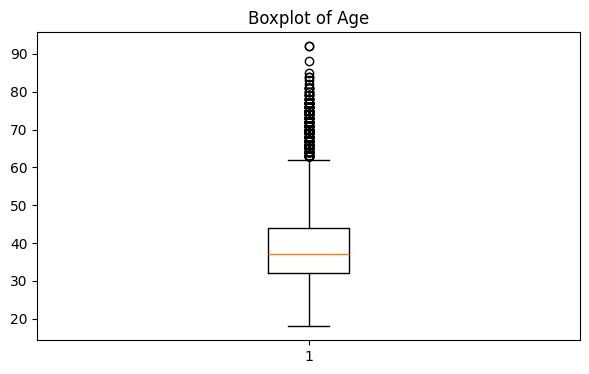

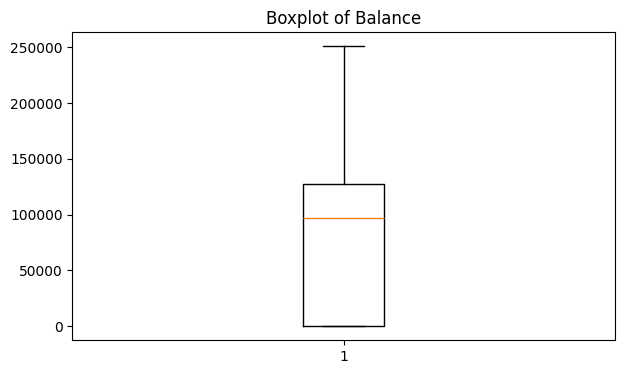

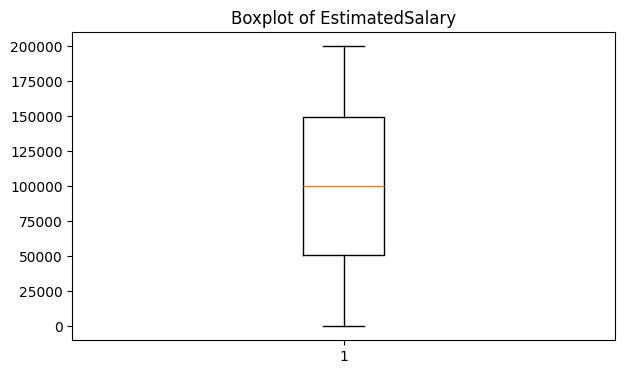

In [ ]:
# Box plots for continuous variables
for var in continuous_vars:
    plt.figure(figsize=(7, 4))
    plt.boxplot(df[var])
    plt.title(f'Boxplot of {var}')
    plt.show()

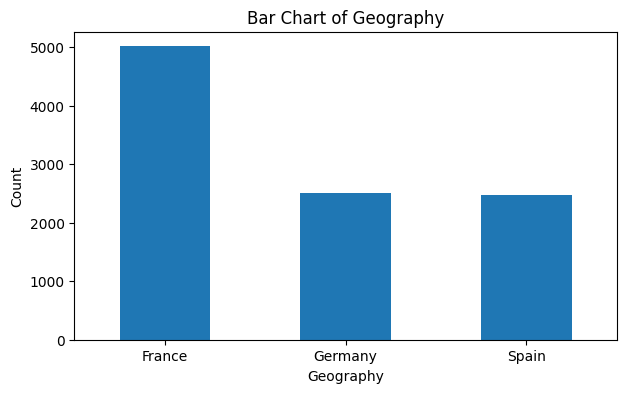

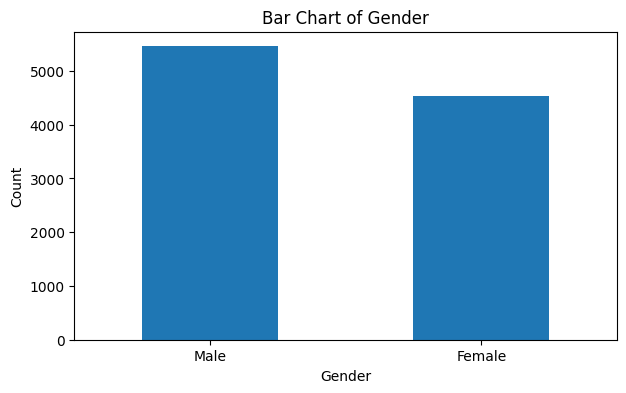

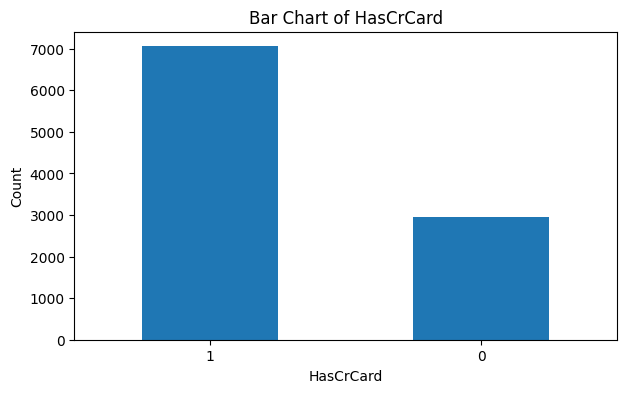

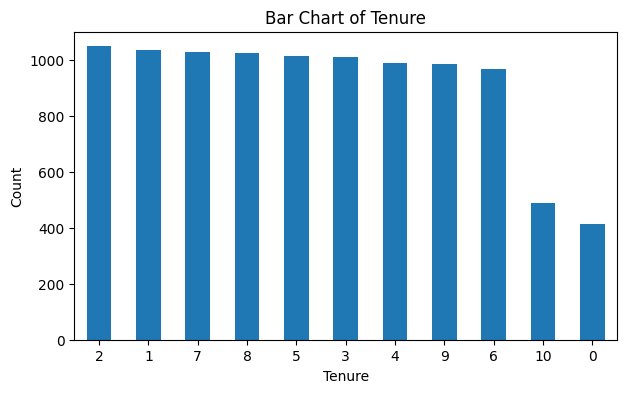

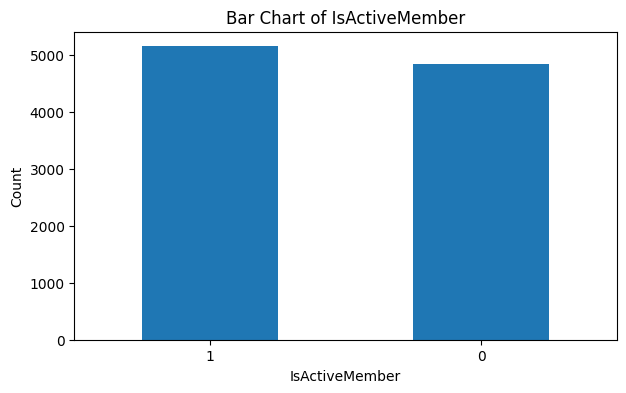

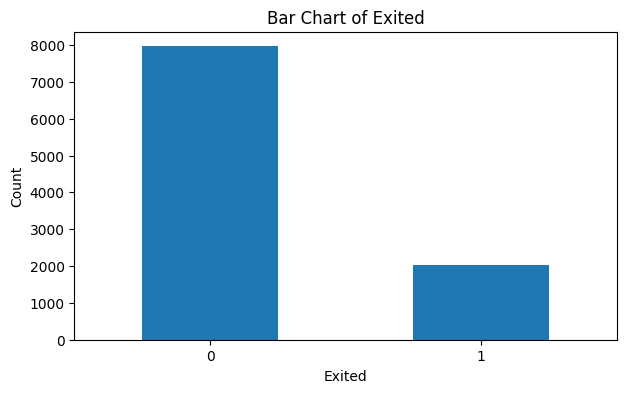

In [ ]:
# Bar charts for categorical variables
categorical_vars = ['Geography', 'Gender', 'HasCrCard', 'Tenure', 'IsActiveMember', 'Exited']

for var in categorical_vars:
    plt.figure(figsize=(7, 4))
    df[var].value_counts().plot(kind='bar')
    plt.title(f'Bar Chart of {var}')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

**Observations**: CreditScore is approximately normally distributed with minimal outliers. Age is skewed to the right. Balance has a high frequency of values between 0 and 25,000, but the remaining values are approximately normally distributed from 25,000 to 225,000. EstimatedSalary has no outliers and has approximately the same frequency for each value.

For Geography, there are significantly more observations of France compared to Germany and Spain. For Gender, there are slightly more male than females. For HasCrCard, twice as many customers have a credit card versus not having a credit card. For Tenure, there is approximately equal distribution across years 1 to 9 with lower frequency for 0 and 10. For IsActiveMember, there are approximately equal distribution across yes and no. For Exited, there are significantly more customers who did *not* exit than customers who did exit.

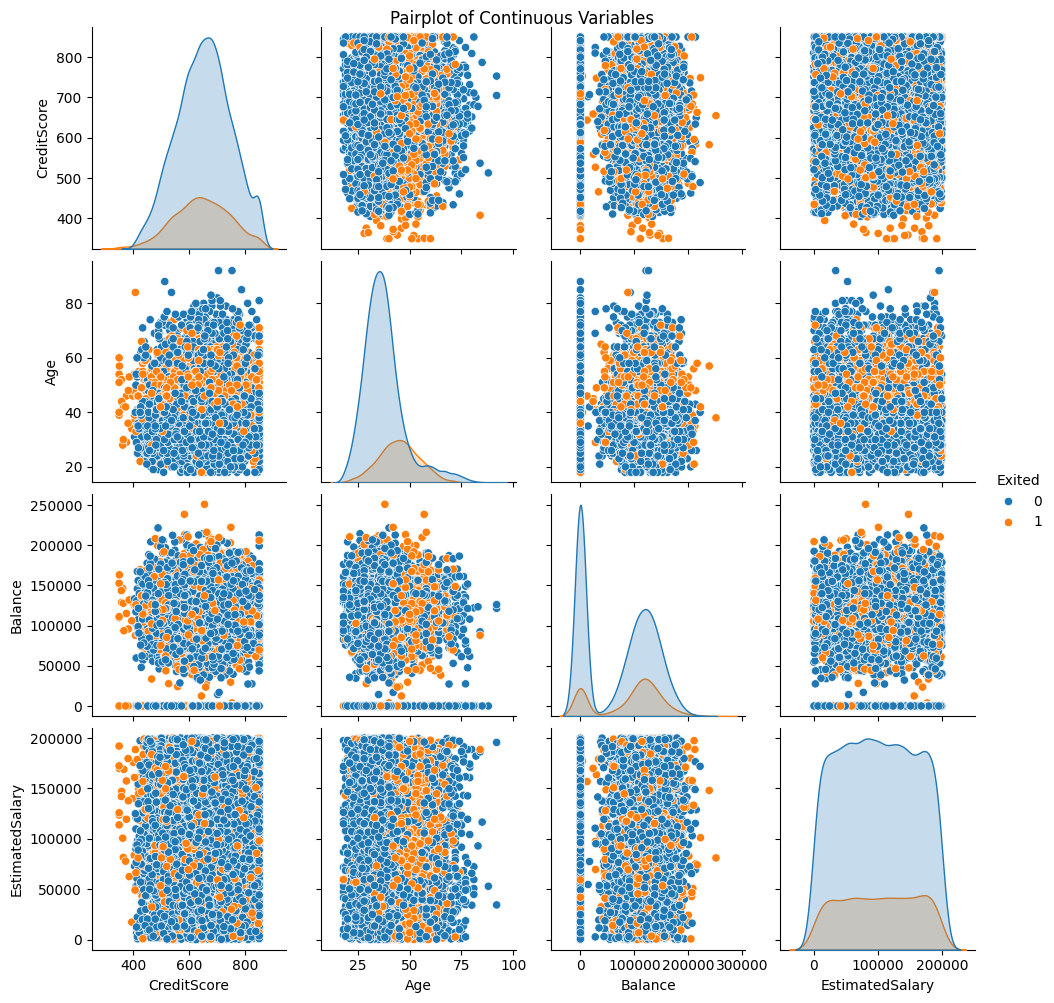

In [ ]:
# Potential Data Visualization for Further Analysis
# Pairplot of continuous variables, churn status is hue
sns.pairplot(df[continuous_vars + ['Exited']], hue='Exited')
plt.suptitle("Pairplot of Continuous Variables", y=1.0)
plt.show()


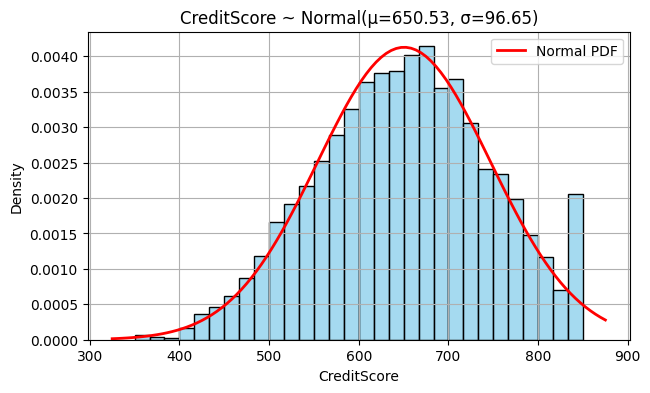

In [ ]:
def plot_norm(vars, df):
  for var in vars:
    plt.figure(figsize=(7, 4))
    sns.histplot(df[var], bins=30, kde=False, stat="density", edgecolor='black', color='skyblue')
    mu, std = norm.fit(df[var])
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    y = norm.pdf(x, mu, std)

    plt.plot(x, y, 'r', lw=2, label=f'Normal PDF')
    plt.title(f'{var} ~ Normal(μ={mu:.2f}, σ={std:.2f})')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_norm(['CreditScore'], df)

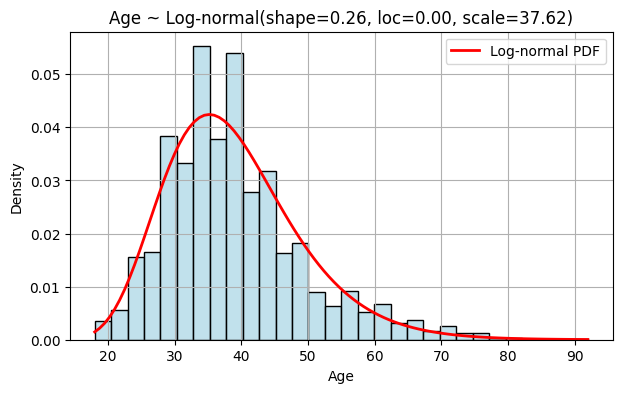

In [ ]:
def plot_lognorm(vars, df):
    for var in vars:
        plt.figure(figsize=(7, 4))
        sns.histplot(df[var], bins=30, kde=False, stat="density", edgecolor='black', color='lightblue')

        shape, loc, scale = lognorm.fit(df[var], floc=0)
        x = np.linspace(df[var].min(), df[var].max(), 100)
        y = lognorm.pdf(x, shape, loc, scale)

        plt.plot(x, y, 'r', lw=2, label=f'Log-normal PDF')
        plt.title(f'{var} ~ Log-normal(shape={shape:.2f}, loc={loc:.2f}, scale={scale:.2f})')
        plt.legend()
        plt.grid(True)
        plt.show()

plot_lognorm(['Age'], df)

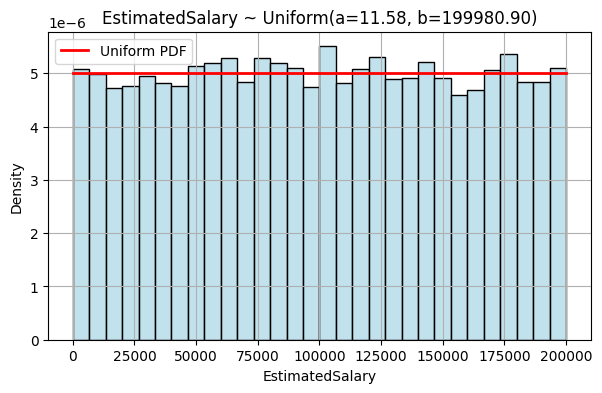

In [ ]:
def plot_u(vars):
  for var in vars:
      plt.figure(figsize=(7, 4))
      sns.histplot(df[var], bins=30, kde=False, stat="density", edgecolor='black', color='lightblue')

      a, b = uniform.fit(df[var])
      x = np.linspace(df[var].min(), df[var].max(), 100)
      y = uniform.pdf(x, a, b)

      plt.plot(x, y, 'r', lw=2, label=f'Uniform PDF')
      plt.title(f'{var} ~ Uniform(a={a:.2f}, b={b:.2f})')
      plt.legend()
      plt.grid(True)
      plt.show()

plot_u(['EstimatedSalary'])

For NONZERO values of Balance, the distribution is:


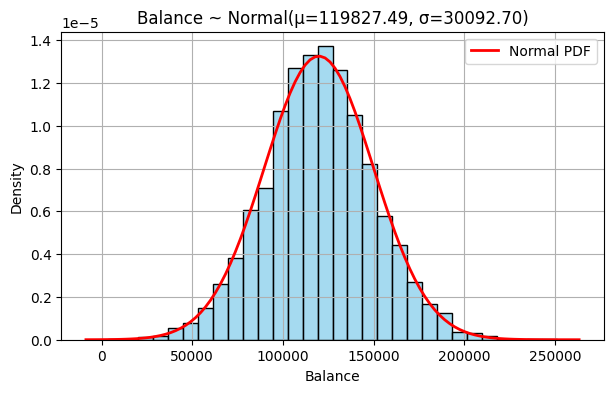

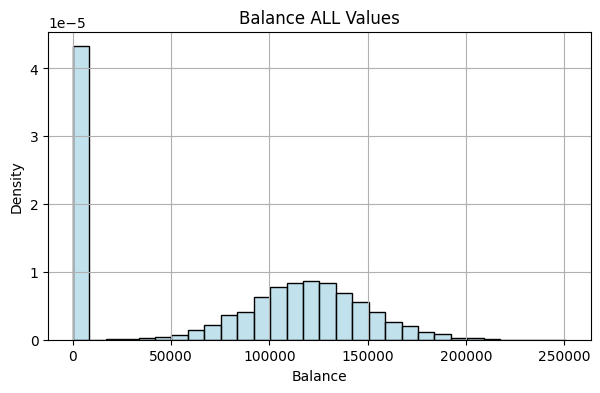

In [ ]:
no_zero_bal = df[df['Balance'] != 0]
print("For NONZERO values of Balance, the distribution is:")
plot_norm(['Balance'], no_zero_bal)

plt.figure(figsize=(7, 4))
sns.histplot(df['Balance'], bins=30, kde=False, stat="density", edgecolor='black', color='lightblue')
plt.title('Balance ALL Values')
plt.grid(True)
plt.show()

**Observations:** For continuous variables, the distributions are as following:


*   CreditScore - approx. normal, spike at 850
*   Age - right skewed, so fit log-normal
*   EstimatedSalary - uniform
*   Balance - spike at 0, approx. normal for non-zero values





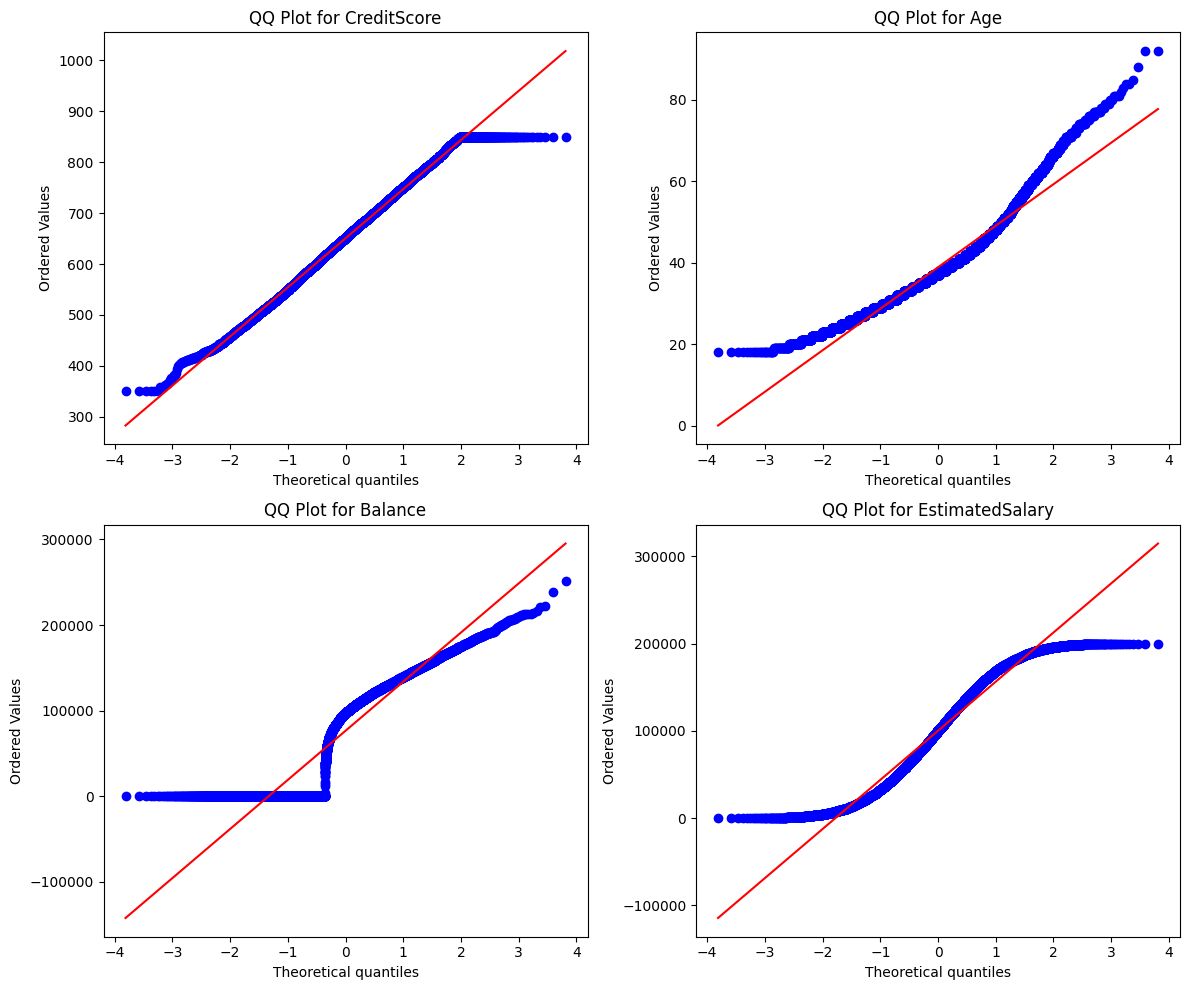

In [ ]:
#QQ plots to test for normality
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, var in zip(axes.flatten(), continuous_vars):
    probplot(df[var], dist="norm", plot=ax)
    ax.set_title(f"QQ Plot for {var}")

plt.tight_layout()
plt.show()

# T-Test

Levene's Test : To check if the variances of the two groups are equal

In [ ]:
# Split churned vs non-churned
churned = df[df['Exited'] == 1]
non_churned = df[df['Exited'] == 0]

In [ ]:
t_test_vars = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure']

for var in t_test_vars:
    stat, p = levene(churned[var], non_churned[var])

    print(f'\n====== Levene’s Test for {var} ======')
    print('Test Statistic:', stat)
    print('P-Value:', p)

    if p < 0.05:
        print(f'Result: Variances are unequal - Use Welch’s T-Test for {var}')
    else:
        print(f'Result: Variances are equal - Use Student’s T-Test for {var}')


====== Levene’s Test for CreditScore ======
Test Statistic: 5.518728902748946
P-Value: 0.018833277253636278
Result: Variances are unequal - Use Welch’s T-Test for CreditScore

====== Levene’s Test for Age ======
Test Statistic: 13.036807257355438
P-Value: 0.00030692323049423515
Result: Variances are unequal - Use Welch’s T-Test for Age

====== Levene’s Test for Balance ======
Test Statistic: 148.11957617010907
P-Value: 7.746401270223993e-34
Result: Variances are unequal - Use Welch’s T-Test for Balance

====== Levene’s Test for EstimatedSalary ======
Test Statistic: 0.9181573634234094
P-Value: 0.3379824239075462
Result: Variances are equal - Use Student’s T-Test for EstimatedSalary

====== Levene’s Test for Tenure ======
Test Statistic: 1.5012891333666953
P-Value: 0.22050197780573186
Result: Variances are equal - Use Student’s T-Test for Tenure




=== CreditScore ===
Churned Mean: 645.3514972999509
Non-Churned Mean: 651.8531960316463


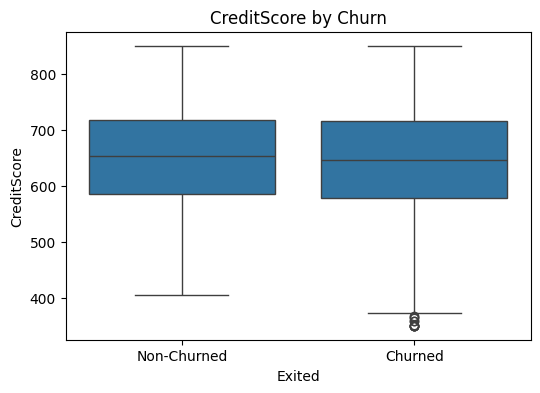

T-Statistic = -2.6347 | P-Value = 0.0085
Significant Difference


=== Age ===
Churned Mean: 44.8379970544919
Non-Churned Mean: 37.40838879819164


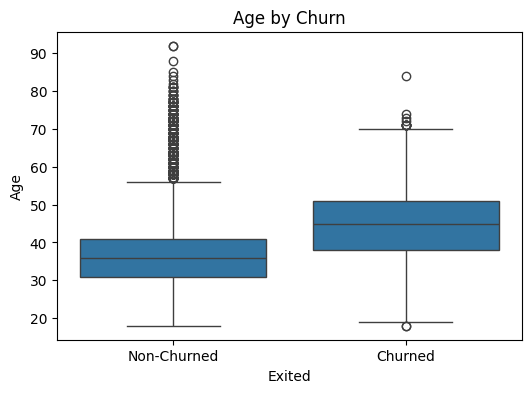

T-Statistic = 30.4192 | P-Value = 0.0000
Significant Difference


=== Balance ===
Churned Mean: 91108.53933726068
Non-Churned Mean: 72745.2967788522


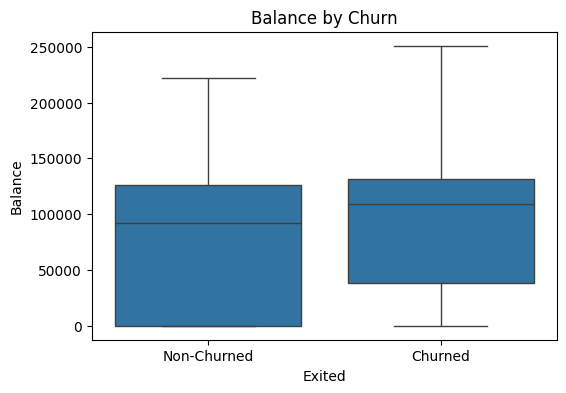

T-Statistic = 12.4713 | P-Value = 0.0000
Significant Difference


=== EstimatedSalary ===
Churned Mean: 101465.67753068237
Non-Churned Mean: 99738.39177194524


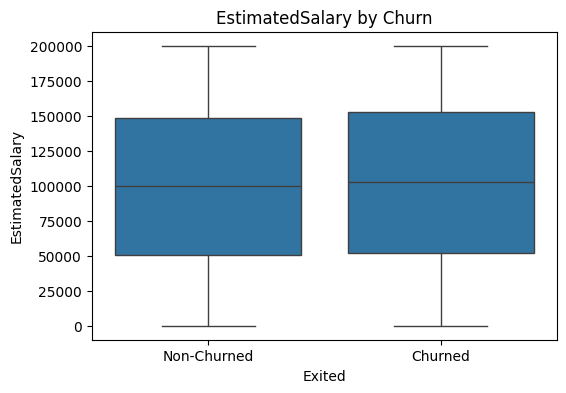

T-Statistic = 1.2034 | P-Value = 0.2289
No Significant Difference


=== Tenure ===
Churned Mean: 4.932744231713304
Non-Churned Mean: 5.033278914981791


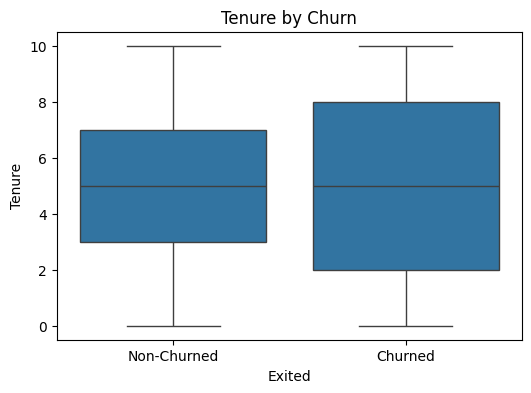

T-Statistic = -1.3843 | P-Value = 0.1664
No Significant Difference


In [ ]:
# Numerical variables for t-test
t_test_vars = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure']

for var in t_test_vars:
    print(f'\n\n=== {var} ===')
    print('Churned Mean:', churned[var].mean())
    print('Non-Churned Mean:', non_churned[var].mean())

# Boxplot for Churn Effect
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Exited', y=var, data=df)
    plt.xticks([0, 1], ['Non-Churned', 'Churned'])
    plt.title(f'{var} by Churn')
    plt.show()

# T-Test (Welch’s Test)
    t_stat, p_val = ttest_ind(churned[var], non_churned[var], equal_var=False)
    print(f'T-Statistic = {t_stat:.4f} | P-Value = {p_val:.4f}')

    if p_val < 0.05:
        print("Significant Difference")
    else:
        print("No Significant Difference")

**CreditScore:**
p-value = 0.0085 < 0.05 -- Significant.

Churned customers have a slightly lower average credit score.

Lower Credit Score may lead to higher churn.

**Age:** p-value = 0.0000 < 0.05 -- Highly Significant.

Churned customers are older on average.

Older customers have higher churn tendency.

**Balance:**
p-value = 0.0000 < 0.05 -- Highly Significant.

Churned customers have higher average bank balance.

Surprising Insight: Customers with more money are leaving.
So possibly due to bad service or better offers elsewhere.

**EstimatedSalary:**
p-value = 0.2289 > 0.05 -- Not Significant.


No major difference in salary between churned & non-churned customers.

Salary does not impact churn much.

**Tenure:**
p-value = 0.1664 > 0.05 -- Not Significant


Number of years spent in the bank has no significant effect on churn.




# Perform Correlation Analysis


Correlation with Churn (Exited):

Age                0.285323
IsActiveMember    -0.156128
Balance            0.118533
NumOfProducts     -0.047820
CreditScore       -0.027094
Tenure            -0.014001
EstimatedSalary    0.012097
HasCrCard         -0.007138
Name: Exited, dtype: float64


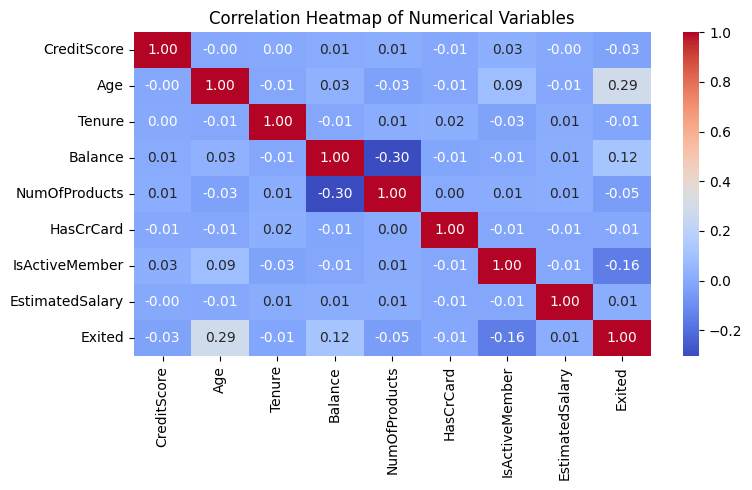

In [ ]:
# Convert 'Exited' to float for correlation calculation
df_corr = df.copy()
df_corr['Exited'] = df_corr['Exited'].astype(float)

# Select only numerical columns
num_cols = df_corr.select_dtypes(include=['float64', 'int64']).columns

# Correlation with churn
correlations = df_corr[num_cols].corr()['Exited'].drop('Exited').sort_values(key=abs, ascending=False)
print("\nCorrelation with Churn (Exited):\n")
print(correlations)


plt.figure(figsize=(8, 5)) # Using Heatmap
sns.heatmap(df_corr[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numerical Variables")
plt.tight_layout()
plt.show()

**Interpretation:-**<br>
- **Age (0.285):** Older customers are more likely to churn. Age has the strongest positive correlation with churn among all numerical features.

- **IsActiveMember (-0.156):** Inactive customers tend to leave more. Being active with the bank lowers churn risk.

- **Balance (0.118):** Customers with higher balances are slightly more likely to churn. Possibly due to better offers from competitors.

- **NumOfProducts (-0.048):** Holding more products slightly reduces churn likelihood, but the effect is weak.

- **Credit Score (-0.027):** Credit score has a very minimal impact on churn, showing a weak negative correlation.

- **Tenure (-0.014):** How long a customer has been with the bank doesn't significantly affect their chance of churning.

- **Estimated Salary (0.012):** Salary has virtually no effect on churn behavior.

- **HasCrCard (-0.007):** Owning a credit card doesn’t influence churn decisions.

# ANOVA / Categorical Variable Analysis

In [ ]:
france_df = df[df['Geography'] == 'France'].reset_index(drop=True)
germany_df = df[df['Geography'] == 'Germany'].reset_index(drop=True)
spain_df = df[df['Geography'] == 'Spain'].reset_index(drop=True)
print(f"Balance variances == France: {np.var(france_df['Balance'])}, Germany: {np.var(germany_df['Balance'])}, Spain: {np.var(spain_df['Balance'])}")
print(f"Age variances == France: {np.var(france_df['Age'])}, Germany: {np.var(germany_df['Age'])}, Spain: {np.var(spain_df['Age'])}")
print(f"CreditScore variances == France: {np.var(france_df['CreditScore'])}, Germany: {np.var(germany_df['CreditScore'])}, Spain: {np.var(spain_df['CreditScore'])}")

Balance variances == France: 4112293900.9493513, Germany: 729897788.903865, Spain: 4124540744.872382
Age variances == France: 109.58771554525819, Germany: 110.608266041374, Spain: 109.07733921557548
CreditScore variances == France: 9410.382016472777, Germany: 9633.299258897552, Spain: 8901.167899947992


In [ ]:
for feature in ['Balance', 'Age', 'CreditScore']:
  stat, p = levene(france_df[feature], germany_df[feature], spain_df[feature])
  print(f'\n====== Levene’s Test for {feature} ======')
  print('Test Statistic:', stat)
  print('P-Value:', p)

  if p < 0.05:
      print(f'Result: Variances are unequal')
  else:
      print(f'Result: Variances are equal')


====== Levene’s Test for Balance ======
Test Statistic: 3344.1395541762836
P-Value: 0.0
Result: Variances are unequal

====== Levene’s Test for Age ======
Test Statistic: 2.0618221992354604
P-Value: 0.12727603114797661
Result: Variances are equal

====== Levene’s Test for CreditScore ======
Test Statistic: 2.4600784434909007
P-Value: 0.0854799646697732
Result: Variances are equal


### ANOVA Balance ~ Geography

In [ ]:
#Welch’s ANOVA for groups with unequal variances
print(pg.welch_anova(dv='Balance', between='Geography', data=df))

      Source  ddof1        ddof2            F  p-unc       np2
0  Geography      2  5528.645137  1981.822371    0.0  0.160893


In [ ]:
#Games-Howell Post-Hoc Test to find which countries differ
print(pg.pairwise_gameshowell(dv='Balance', between='Geography', data=df))

         A        B        mean(A)        mean(B)          diff           se  \
0   France  Germany   62092.636516  119730.116134 -57637.479618  1054.207645   
1   France    Spain   62092.636516   61818.147763    274.488752  1576.747915   
2  Germany    Spain  119730.116134   61818.147763  57911.968370  1398.869501   

           T           df          pval    hedges  
0 -54.673745  7351.446851  2.555955e-12 -1.054843  
1   0.174085  4925.133185  9.834315e-01  0.004277  
2  41.399121  3316.776713  0.000000e+00  1.177709  


**Observations:** Since the variances are unequal across the country groups for Balance values of customers, we can not perform the normal one-way ANOVA tests, since this method assumes equal variance across the groups. In place of a standard F-test or other non-parametric process, we used a Welch's ANOVA Test, which doesn't assume equal variances. Since there was a diffrence in means identified, we used Games-Howell as a post-hoc test to find which country was different. This is similar to Tuley's Test but does not assume equal variances.  

### ANOVA Age ~ Geography

In [ ]:
#Unbalanced sample size for each group of Geography
def anova_with_geo_unbalanced(feature, df):
  grouped_data = [df[df['Geography'] == geo][feature] for geo in df['Geography'].unique()]

  f_stat, p_value = f_oneway(*grouped_data)

  # Degrees of freedom
  I = len(grouped_data)  #num of groups
  N = len(df)            #total number of observations
  df_between = I - 1
  df_within = N - I      #total num - num of groups
  df_total = N - 1

  print(f"== ANOVA test for {feature} ~ Geography ==")
  print(f"F-statistic: {f_stat:.4f}")
  print(f"p-value: {p_value:.4f}")
  print(f"Degrees of Freedom: df_between = {df_between}, df_within = {df_within}, df_total = {df_total}")

  if p_value < 0.05:
      print("Significant Difference")
  else:
      print("No Significant Difference")

  plt.figure(figsize=(7, 4))
  sns.boxplot(data=df, x='Geography', y=feature)
  plt.title(f'{feature} by Geography on Unequal Sample Sizes')
  plt.grid(True)
  plt.show()

== ANOVA test for Age ~ Geography ==
F-statistic: 12.1063
p-value: 0.0000
Degrees of Freedom: df_between = 2, df_within = 9997, df_total = 9999
Significant Difference


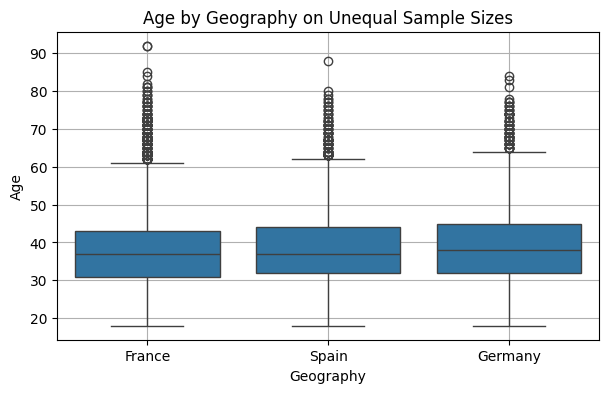

In [ ]:
anova_with_geo_unbalanced('Age', df)

In [ ]:
#Complete random sampling for equal sample sizes from each group, so we have a balanced sample ANOVA design
np.random.seed(42)

min_group_size = df['Geography'].value_counts().min() #make sample size the minimum size across the groups
sampled_groups = []
for name, group in df.groupby('Geography'):
    sampled_group = group.sample(n=min_group_size, random_state=42)
    sampled_groups.append(sampled_group)

sampled_groups_df = pd.concat(sampled_groups, axis=0).reset_index(drop=True) #new df with equal sample sizes for geography groups

def anova_with_geo_balanced(feature, sampled_groups_df, min_group_size):
  sample_grouped_balances = [group[feature].values for _, group in sampled_groups_df.groupby('Geography')]
  f_stat, p_val = f_oneway(*sample_grouped_balances)

  # Degrees of freedom
  I = len(sampled_groups_df['Geography'].unique())  #num of groups
  J = min_group_size  #sample size of the groups
  df_between = I - 1
  df_within = I*(J - 1)
  df_total = I*J - 1

  print(f"The sample size for each groups is {min_group_size}")
  print(f"The total sample size is {min_group_size*I}")
  print(f"\n== ANOVA test for {feature} ~ Geography ==")
  print(f"F-statistic: {f_stat:.4f}")
  print(f"p-value: {p_val:.4e}")
  print(f"Degrees of Freedom: df_between = {df_between}, df_within = {df_within}, df_total = {df_total}")

  if p_val < 0.05:
      print("Significant Difference")
  else:
      print("No Significant Difference")

  plt.figure(figsize=(7, 4))
  sns.boxplot(data=sampled_groups_df, x='Geography', y=feature)
  plt.title(f'{feature} by Geography on Equal Sample Sizes')
  plt.grid(True)
  plt.show()

The sample size for each groups is 2477
The total sample size is 7431

== ANOVA test for Age ~ Geography ==
F-statistic: 11.7319
p-value: 8.1831e-06
Degrees of Freedom: df_between = 2, df_within = 7428, df_total = 7430
Significant Difference


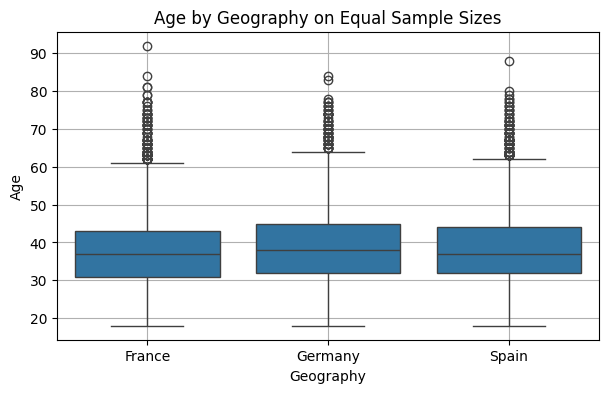

In [ ]:
anova_with_geo_balanced('Age', sampled_groups_df ,min_group_size)

In [ ]:
#Since there is a significant difference, completed Tukey's test to find which ones differ
#Calculate the testing statistic for each pair
def tukey_func(group_name, num_name, df):
  groups = df.groupby(group_name)[num_name]
  means = groups.mean()
  print(" == Group means: ==\n", means)

  tukey = pairwise_tukeyhsd(endog=df[num_name], groups=df[group_name], alpha=0.05)
  print("\n")
  print(tukey)

  group_vals = [group for name, group in groups]
  F, p = f_oneway(*group_vals)
  n_groups = len(group_vals)
  n_total = sum([len(g) for g in group_vals])
  df_w = n_total - n_groups
  ss_w = sum([((g - g.mean())**2).sum() for g in group_vals])
  ms_w = ss_w / df_w
  print("\nMS_within (pooled variance):", ms_w)

  group_sizes = groups.size()
  se_dict = {}
  for (g1, g2) in itertools.combinations(groups.groups.keys(), 2):
      n1, n2 = group_sizes[g1], group_sizes[g2]
      se = np.sqrt(ms_w * (1/n1 + 1/n2))
      mean_diff = abs(means[g1] - means[g2])
      q = mean_diff / se
      se_dict[f"{g1} vs {g2}"] = {"q_stat": q, "SE": se}

  for pair, stats in se_dict.items():
      print(f"{pair}: q = {stats['q_stat']:.4f}, SE = {stats['SE']:.2f}")

In [ ]:
tukey_func('Geography', 'Age', sampled_groups_df)

 == Group means: ==
 Geography
France     38.299152
Germany    39.733145
Spain      38.890997
Name: Age, dtype: float64


 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
 France Germany    1.434    0.0  0.7365  2.1315   True
 France   Spain   0.5918 0.1149 -0.1056  1.2893  False
Germany   Spain  -0.8421 0.0129 -1.5396 -0.1447   True
------------------------------------------------------

MS_within (pooled variance): 109.64250218868735
France vs Germany: q = 4.8195, SE = 0.30
France vs Spain: q = 1.9891, SE = 0.30
Germany vs Spain: q = 2.8304, SE = 0.30


**Observations:** Germany is significantly different from the other two countries when comparing the means of Age. In both calculations where the sample size was unequal and equal, the F-statistic is large and the p-value is approximately 0, so we reject the null hypothesis and determine that there is at least one group mean that is different from the others. Further analysis can be completed with Tukey's test on the resampled data. It shows that Germany is the significant different group, since all pairs including this country has p-values less than an alpha of 0.05.

### ANOVA CreditScore ~ Geography

== ANOVA test for CreditScore ~ Geography ==
F-statistic: 0.3994
p-value: 0.6707
Degrees of Freedom: df_between = 2, df_within = 9997, df_total = 9999
No Significant Difference


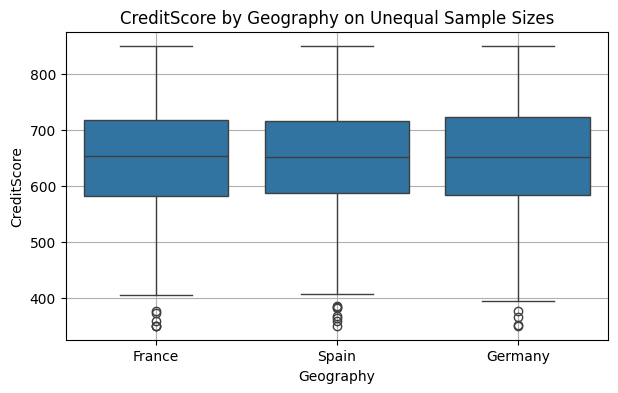

In [ ]:
anova_with_geo_unbalanced('CreditScore', df)

The sample size for each groups is 2477
The total sample size is 7431

== ANOVA test for CreditScore ~ Geography ==
F-statistic: 0.4862
p-value: 6.1498e-01
Degrees of Freedom: df_between = 2, df_within = 7428, df_total = 7430
No Significant Difference


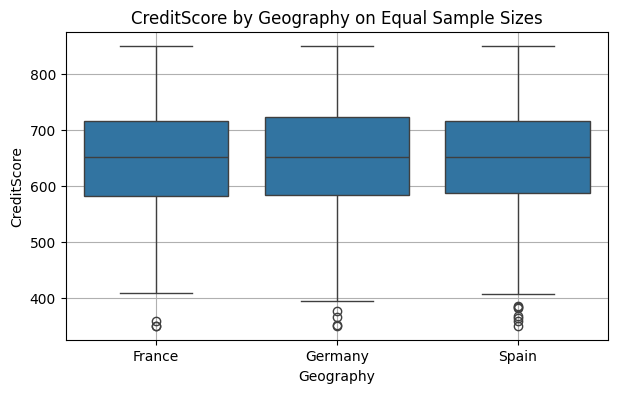

In [ ]:
anova_with_geo_balanced('CreditScore', sampled_groups_df ,min_group_size)

**Observations:** Based on the ANOVA test, there is no significant difference between the means of CreditScore across different Geography. In both calculations where the sample size was unequal and equal, the F-statistic is very small and the p-value is above the alpha values of 0.5.We fail to reject the null hypothesis and determine that there is all the group means are the same. No further analysis is needed with Tukey's test, since no difference exists on the resampled data.

### ANOVA All Numerical Features ~ Exited

In [ ]:
# Store results
anova_results = []

for var in quantitative_vars:
    group_0 = df[df['Exited'] == 0][var]
    group_1 = df[df['Exited'] == 1][var]

    f_stat, p_val = f_oneway(group_0, group_1)
    anova_results.append({
        'Variable': var,
        'F-statistic': f_stat,
        'p-value': p_val
    })

# Create a summary DataFrame
anova_df = pd.DataFrame(anova_results)
anova_df['Reject (p < 0.05)'] = anova_df['p-value'] < 0.05

print("== ANOVA 'Feature' ~ Exited ==\n")
print(anova_df.sort_values('p-value'))


== ANOVA 'Feature' ~ Exited ==

          Variable  F-statistic        p-value  Reject (p < 0.05)
1              Age   886.063275  1.239931e-186               True
3          Balance   142.473832   1.275563e-32               True
4    NumOfProducts    22.915223   1.717333e-06               True
0      CreditScore     7.344522   6.738214e-03               True
2           Tenure     1.960164   1.615268e-01              False
5  EstimatedSalary     1.463262   2.264404e-01              False


# Chi Squared Test of Independence

In [ ]:
from scipy.stats import chi2_contingency

# List of categorical variables to test against churn
cat_vars = ['Gender', 'Geography', 'HasCrCard', 'IsActiveMember']

print("=== Chi-Square Test of Independence ===\n")

for var in cat_vars:
    print(f"\nChi-Square Test: {var} vs Exited")
    contingency_table = pd.crosstab(df[var], df['Exited'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print("Contingency Table:\n", contingency_table)
    print(f"Chi2 Statistic = {chi2:.4f} | p-value = {p:.4f} | Degrees of Freedom = {dof}")

    if p < 0.05:
        print("Result: Reject Null Hypothesis - There is a significant relationship.")
    else:
        print("Result: Fail to Reject Null Hypothesis - No significant relationship.")

=== Chi-Square Test of Independence ===


Chi-Square Test: Gender vs Exited
Contingency Table:
 Exited     0     1
Gender            
Female  3404  1139
Male    4559   898
Chi2 Statistic = 112.9186 | p-value = 0.0000 | Degrees of Freedom = 1
Result: Reject Null Hypothesis - There is a significant relationship.

Chi-Square Test: Geography vs Exited
Contingency Table:
 Exited        0    1
Geography           
France     4204  810
Germany    1695  814
Spain      2064  413
Chi2 Statistic = 301.2553 | p-value = 0.0000 | Degrees of Freedom = 2
Result: Reject Null Hypothesis - There is a significant relationship.

Chi-Square Test: HasCrCard vs Exited
Contingency Table:
 Exited        0     1
HasCrCard            
0          2332   613
1          5631  1424
Chi2 Statistic = 0.4713 | p-value = 0.4924 | Degrees of Freedom = 1
Result: Fail to Reject Null Hypothesis - No significant relationship.

Chi-Square Test: IsActiveMember vs Exited
Contingency Table:
 Exited             0     1
IsActiveMem

**Interpretation:**

- The Chi-Square Test of Independence was performed to check if categorical variables are significantly associated with customer churn **(Exited)**.

**Significant Relationships Identified:**
- The Gender, Geography, and IsActiveMember all p-values < **0.05**.
- This reveals that there is a statistically significant relationship with churn.
- The variables are not independent of churn — the churned vs. retained customers distribution is different in their categories.

**Non-Significant Relationship:**
- HasCrCard had a p-value = 0.4924, which is greater than **0.05**.
- This suggests that having a credit card does not significantly influence a customer’s likelihood to churn.<br>

-Variables with significant results (Gender, Geography, IsActiveMember) can be important predictors in churn modeling.<br>
-These findings can guide targeted retention strategies and improve the interpretability of churn prediction models.

# Mulitple Linear Regression

In [ ]:
#Since age has a significant impact on exited
#Form predictive model to determine age of customer based on if the customer exited and other features
y = df['Age']
X = df[['CreditScore', 'Balance', 'Gender', 'Geography', 'Exited']] #5 chosen variables

#Get dummy variables for categorical variables
X_dummy = pd.get_dummies(X, drop_first=True).astype(float)
X_dummy = sm.add_constant(X_dummy) #intercept
model = sm.OLS(y, X_dummy)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    Age   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     148.1
Date:                Sun, 04 May 2025   Prob (F-statistic):          1.33e-180
Time:                        23:28:12   Log-Likelihood:                -37265.
No. Observations:               10000   AIC:                         7.454e+04
Df Residuals:                    9993   BIC:                         7.459e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                37.0661      0.71

In [ ]:
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [ ]:
#Form predictive model to determine age of customer based on all other features
y = df['Age']
X = df[['Exited', 'Balance', 'Geography', 'Tenure', 'CreditScore', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']] #all chosen variables

#Get dummy variables for categorical variables
X_dummy = pd.get_dummies(X, drop_first=True).astype(float)
X_dummy = sm.add_constant(X_dummy) #intercept
model = sm.OLS(y, X_dummy)
results = model.fit()
print(f'== MLR for Age ==\n {results.summary()}')

== MLR for Age ==
                             OLS Regression Results                            
Dep. Variable:                    Age   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     110.4
Date:                Sun, 04 May 2025   Prob (F-statistic):          1.31e-218
Time:                        23:28:12   Log-Likelihood:                -37167.
No. Observations:               10000   AIC:                         7.436e+04
Df Residuals:                    9989   BIC:                         7.444e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              

In [ ]:
#Form predictive model to determine age of customer based on only significant features
y = df['Age']
X = df[['Exited','NumOfProducts', 'IsActiveMember']] #significant chosen variables

#Get dummy variables for categorical variables
X_dummy = pd.get_dummies(X, drop_first=True).astype(float)
X_dummy = sm.add_constant(X_dummy) #intercept
model = sm.OLS(y, X_dummy)
results = model.fit()
print(f'== MLR for Age ==\n {results.summary()}')

== MLR for Age ==
                             OLS Regression Results                            
Dep. Variable:                    Age   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     366.3
Date:                Sun, 04 May 2025   Prob (F-statistic):          1.06e-225
Time:                        23:28:12   Log-Likelihood:                -37170.
No. Observations:               10000   AIC:                         7.435e+04
Df Residuals:                    9996   BIC:                         7.438e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             36.3405

In [ ]:
#Form predictive model to determine balance of customer based on all features
y = df['Balance']
X = df[['Exited', 'Age', 'Geography', 'Tenure', 'CreditScore', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']] #all chosen variables

#Get dummy variables for categorical variables
X_dummy = pd.get_dummies(X, drop_first=True).astype(float)
X_dummy = sm.add_constant(X_dummy) #intercept
model = sm.OLS(y, X_dummy)
results = model.fit()
print(f'== MLR for Balance ==\n {results.summary()}')

== MLR for Balance ==
                             OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     338.2
Date:                Sun, 04 May 2025   Prob (F-statistic):               0.00
Time:                        23:28:12   Log-Likelihood:            -1.2314e+05
No. Observations:               10000   AIC:                         2.463e+05
Df Residuals:                    9989   BIC:                         2.464e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const          

In [ ]:
#Form predictive model to determine balance of customer based on all features
y = df['Balance']
X = df[['Exited', 'NumOfProducts', 'HasCrCard', 'Geography']] #significant chosen variables

#Get dummy variables for categorical variables
X_dummy = pd.get_dummies(X, drop_first=True).astype(float)
X_dummy = sm.add_constant(X_dummy) #intercept
model = sm.OLS(y, X_dummy)
results = model.fit()
print(f'== MLR for Balance ==\n {results.summary()}')

== MLR for Balance ==
                             OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     675.2
Date:                Sun, 04 May 2025   Prob (F-statistic):               0.00
Time:                        23:28:12   Log-Likelihood:            -1.2315e+05
No. Observations:               10000   AIC:                         2.463e+05
Df Residuals:                    9994   BIC:                         2.463e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const          

**Observations:** When using all feature to predict age, the model has a 0.081 adjusted R^2, which means it explains 8.1% of the variance in age. This is very low and likely indicates that the features are not strong predictors of age. The model is represented as: age =

The model to predict age with selected features that are significant is: age=36.3405−0.3130⋅(NumOfProducts)+2.7973⋅(IsActiveMember)+7.9499⋅(Exited_1)

This model has less features and the same adjusted R^2 value.

When using all feature to predict balance, the model has a 0.252 adjusted R^2, which means it explains 25.2% of the variance in balance. This is very low and likely indicates that the features are not strong predictors of balance. The model is represented as: balance = 109800−69.21⋅(Age)−152.16⋅(Tenure)+ 5.52⋅(CreditScore)−32040⋅(NumOfProducts)−2392.60⋅(HasCrCard)+ 958.11⋅(IsActiveMember)+ 0.0135⋅(EstimatedSalary)+ 6302.03⋅(Exited_1)+ 56350⋅(Geography_Germany)− 49.67⋅(Geography_Spain)

The model to predict balance with selected features that are significant is: balance=1.119e+05-3.2e+04⋅(NumOfProducts)-2436.5673⋅(HasCrCard)+5600.3375•(Exited_1)+ 5.638e+04⋅(Geography_Germany)-61.9879⋅(Geography_Spain)

This model has less features and the same adjusted R^2 value.

It does not seem reasonable to accurately predict the values of age and balance of the customers at the bank.

# Logistic Regression


In [ ]:
# Select Features (Independent Variables)
X = df[['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure']]

# Target Variable
y = df['Exited']

# Split Data into Train & Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build Logistic Regression Model
log_model = LogisticRegression(max_iter=1000, class_weight='balanced')
log_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

Logistic Regression with class_weight='balanced' is used to handle class imbalance and ensure that both churned and non-churned customers are treated equally important.



In [ ]:
# Predictions
y_pred = log_model.predict(X_test)

# Accuracy
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Accuracy Score: 0.6936666666666667


Dataset was split as: 70% Training Data and 30% Testing Data

Prediction: The model was trained on customer features and predicted churn labels for test data.

Accuracy: The model correctly predicted around 69% of the customers from the test dataset.


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[1693  723]
 [ 196  388]]


Confusion Matrix Interpretation:

True Negatives (TN) - 1693 - Correct prediction of non-churned customers.

False Positives (FP) - 723 - Predicted churn, but customer did not churn.

False Negatives (FN) - 196 - Predicted non-churn, but customer actually churned.

True Positives (TP) - 388 - Correct prediction of churned customers.

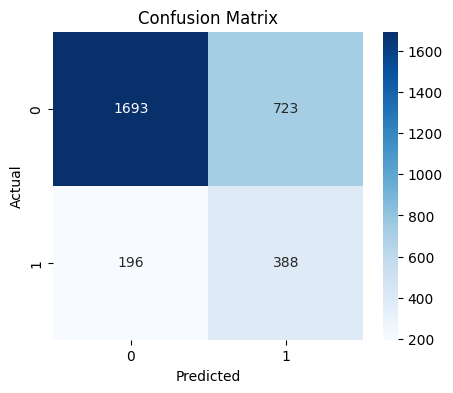

In [ ]:
# Visualization of Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.70      0.79      2416
           1       0.35      0.66      0.46       584

    accuracy                           0.69      3000
   macro avg       0.62      0.68      0.62      3000
weighted avg       0.79      0.69      0.72      3000



**Non-Churn Customers:**

Precision = 90% -- The model is highly accurate in predicting non-churned customers.

Recall = 70% -- The model successfully identifies 70% of non-churned customers.

**Churn Customers:**

Precision = 35% -- Indicates that some non-churn customers are misclassified as churn.

Recall = 66% -- Indicates that the model successfully identified 66% of churned customers.

F1-Score = 0.46 -- Reflects a balance between precision and recall for churn prediction.

AUC Score: 0.7412080139254287


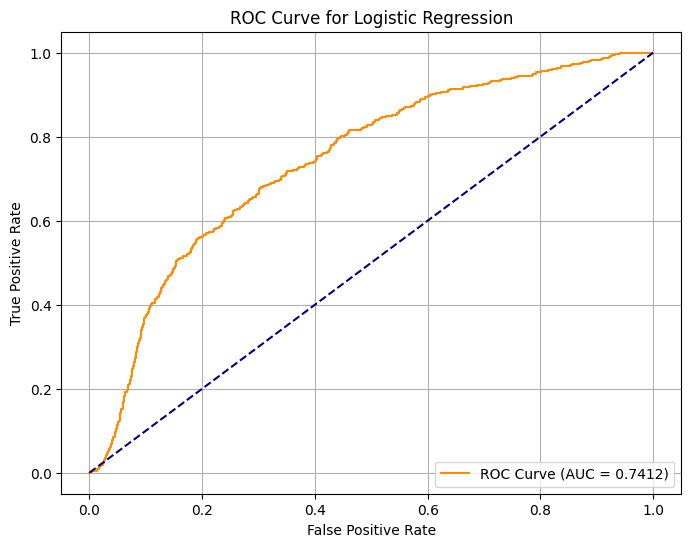

In [ ]:
# Predict probabilities
y_pred_prob = log_model.predict_proba(X_test)[:,1]

# Calculate ROC Curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate AUC Score
auc_score = roc_auc_score(y_test, y_pred_prob)
print("AUC Score:", auc_score)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0,1], [0,1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.grid()
plt.show()

The orange curve is well above the diagonal line (blue dashed line). This shows the model performs better than random guessing.

AUC of 0.7412 indicates a good separation capability between churn and non-churn customers.



# Lasso Regression

In [ ]:
# Select numerical + categorical features
X = df.drop(['Exited'], axis=1)
y = df['Exited']

In [ ]:
# Convert categorical variables to dummy variable
X = pd.get_dummies(X, drop_first=True)

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# Lasso with cross-validation
lasso = LassoCV(cv=5, random_state=0)
lasso.fit(X_train, y_train)

LassoCV(cv=5, random_state=0)

In [ ]:
# Coefficients
lasso_coef = pd.Series(lasso.coef_, index=X.columns)
selected_features = lasso_coef[lasso_coef != 0]

print("\nSelected Features by Lasso Regression:")
print(selected_features.sort_values(key=abs, ascending=False))


Selected Features by Lasso Regression:
Age                  0.115066
IsActiveMember      -0.069862
Geography_Germany    0.053702
Gender_Male         -0.036751
Balance              0.018426
NumOfProducts       -0.008815
CreditScore         -0.008422
Tenure              -0.004210
Geography_Spain      0.002901
EstimatedSalary      0.001628
HasCrCard           -0.000011
dtype: float64


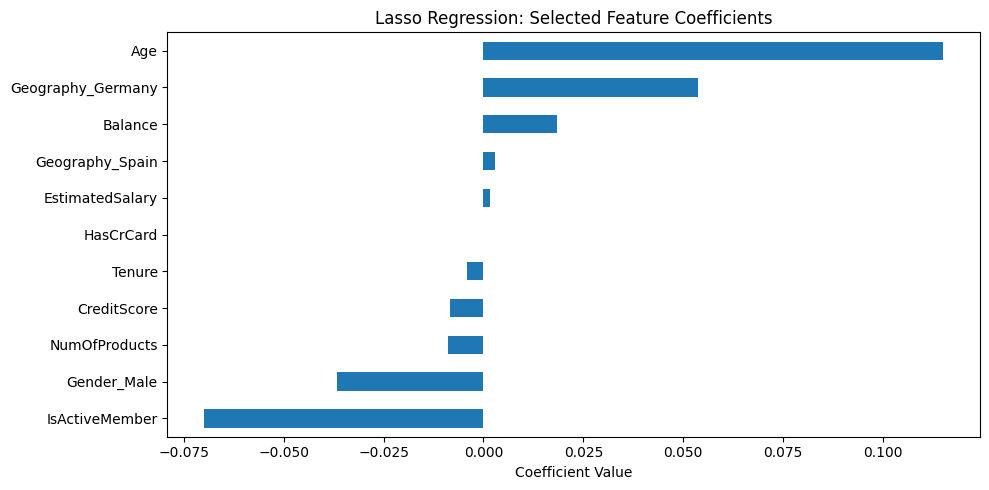

In [ ]:
# Plot coefficients
plt.figure(figsize=(10, 5))
selected_features.sort_values().plot(kind='barh')
plt.title("Lasso Regression: Selected Feature Coefficients")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

**Interpretation:**
- LassoCV was used to perform Lasso Regression with cross-validation, which helps select the best regularization parameter automatically.
- Features were standardized using StandardScaler, which is important because Lasso is sensitive to the scale of input features.
- Categorical variables such as Gender and Geography were converted to dummy variables using one-hot encoding (with drop_first=True to avoid multicollinearity).
- Lasso regression identified and retained features that have non-zero coefficients, effectively performing feature selection.
- The most influential feature was Age, with a positive coefficient, indicating that as age increases, the likelihood of churn increases.
- Geography_Germany also had a positive coefficient, meaning customers from Germany are more likely to churn.
- IsActiveMember had a strong negative coefficient, suggesting that active members are less likely to leave the bank.
- Other features like Gender_Male, NumOfProducts, and CreditScore also showed some impact, though less than the top features.
- Features such as HasCrCard, Tenure, and EstimatedSalary had coefficients close to zero, implying minimal or no influence on churn prediction.
- The visualization of coefficients helped confirm which features have meaningful relationships with churn and which ones can be safely excluded from further modeling.